In [1]:
from dotenv import load_dotenv

load_dotenv()

True

### Nodes & Edges

In [2]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph
import time

def add_one(input: list[HumanMessage]):
    input[0].content = input[0].content + "a"
    time.sleep(1)
    return input


graph = MessageGraph()

graph.add_node("branch_a", add_one)
graph.add_edge("branch_a", "branch_b")
graph.add_edge("branch_a", "branch_c")

graph.add_node("branch_b", add_one)
graph.add_node("branch_c", add_one)

graph.add_edge("branch_b", "final_node")
graph.add_edge("branch_c", "final_node")

graph.add_node("final_node", add_one)
graph.add_edge("final_node", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

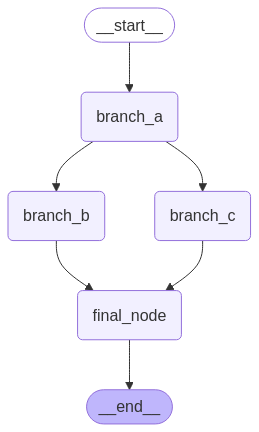

In [3]:
from IPython.display import Image, display

display(Image(runnable.get_graph().draw_mermaid_png()))

In [4]:
runnable.invoke("a")

[HumanMessage(content='aaaaa', additional_kwargs={}, response_metadata={}, id='4ab57c53-d2fc-415f-9dc9-65292f329793')]

### Conditional Edges

In [5]:
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph


def entry(input: list[HumanMessage]):
    return input


def work_with_b(input: list[HumanMessage]):
    print("Using branch B")
    return input


def work_with_c(input: list[HumanMessage]):
    print("Using branch C")
    return input


def router(input: list[HumanMessage]):
    if "use_b" in input[0].content:
        return "branch_b"
    else:
        return "branch_c"


graph = MessageGraph()

graph.add_node("branch_a", entry)
graph.add_node("branch_b", work_with_b)
graph.add_node("branch_c", work_with_c)

graph.add_conditional_edges(
    "branch_a", router, {"branch_b": "branch_b", "branch_c": "branch_c"}
)
graph.add_edge("branch_b", END)
graph.add_edge("branch_c", END)

graph.set_entry_point("branch_a")

runnable = graph.compile()

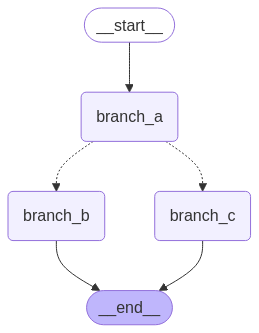

In [7]:
display(Image(runnable.get_graph().draw_mermaid_png()))

In [8]:
runnable.invoke("hello")

Using branch C


[HumanMessage(content='hello', additional_kwargs={}, response_metadata={}, id='cc4b9226-9145-490c-b572-d1116925406c')]

In [9]:
runnable.invoke("I want to use_b")

Using branch B


[HumanMessage(content='I want to use_b', additional_kwargs={}, response_metadata={}, id='5c7f5d42-1f56-42cd-afe0-bb1523f986dc')]

### Cycles

In [10]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.graph import END, MessageGraph

model = ChatOpenAI(temperature=0)


def entry(input: list[HumanMessage]):
    return input


def action(input: list[HumanMessage]):
    print("Action taken:", [msg.content for msg in input])
    if len(input) > 5:
        input.append(HumanMessage(content="end"))
    else:
        input.append(HumanMessage(content="continue"))
    return input


def should_continue(input: list):
    last_message = input[-1]
    if "end" in last_message.content:
        return "__end__"
    return "action"


graph = MessageGraph()

graph.add_node("agent", entry)
graph.add_node("action", action)

graph.add_conditional_edges(
    "agent", should_continue, {"action": "action", "__end__": END}
)
graph.add_edge("action", "agent")

graph.set_entry_point("agent")

runnable = graph.compile()

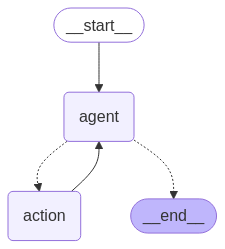

In [11]:
display(Image(runnable.get_graph().draw_mermaid_png()))

In [12]:
runnable.invoke("Hello")

Action taken: ['Hello']
Action taken: ['Hello', 'continue']
Action taken: ['Hello', 'continue', 'continue']
Action taken: ['Hello', 'continue', 'continue', 'continue']
Action taken: ['Hello', 'continue', 'continue', 'continue', 'continue']
Action taken: ['Hello', 'continue', 'continue', 'continue', 'continue', 'continue']


[HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}, id='64deb5ff-c920-441d-b0c1-6ad919d3a89c'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='ec52286f-dccb-44f5-8b0f-94d46aee6bf8'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='2784a719-3ac2-421d-a4ab-b1d8de6640cc'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='add41321-ed1e-4dad-8370-b1a6a0a0e961'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='3e7c824d-3cf7-4743-bbc6-864c9c2dc5f5'),
 HumanMessage(content='continue', additional_kwargs={}, response_metadata={}, id='cda62367-4abd-4678-bc27-657db5079a13'),
 HumanMessage(content='end', additional_kwargs={}, response_metadata={}, id='5909eeea-7219-4e5f-b736-cf31be246dd5')]

### Real Agent - now lets create an Agent that actually does something

In [13]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)

In [14]:
from typing import TypedDict, Annotated, Sequence
import operator
from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    api_call_count: int = 0

In [15]:
from langchain_core.tools import tool
import random


@tool
def fake_weather_api(city: str) -> str:
    """Check the weather in a specified city. The API is available randomly, approximately every third call."""

    if random.randint(1, 3) == 1:  # Approximately one-third chance
        return "Sunny, 22°C"
    else:
        return "Service temporarily unavailable"

In [16]:
print(fake_weather_api("New York"))
print(fake_weather_api("London"))
print(fake_weather_api("Berlin"))

Sunny, 22°C
Service temporarily unavailable
Service temporarily unavailable


/var/folders/zc/ry4mrzj90hl8qhxlk6pk0sr40000gn/T/ipykernel_54918/3103669300.py:1: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  print(fake_weather_api("New York"))


In [17]:
llm_with_tools = model.bind_tools([fake_weather_api])

In [18]:
from langchain_core.messages import HumanMessage, ToolMessage

tool_mapping = {"fake_weather_api": fake_weather_api}

messages = [
    HumanMessage(
        "How will the weather be in munich today? I would like to eat outside if possible"
    )
]
llm_output = llm_with_tools.invoke(messages)
messages.append(llm_output)
print(messages)

[HumanMessage(content='How will the weather be in munich today? I would like to eat outside if possible', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2Qop2iEb6dJYE56qd5i1h3Eh', 'function': {'arguments': '{"city":"Munich"}', 'name': 'fake_weather_api'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 76, 'total_tokens': 94, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-10fcb0bb-a219-4c97-814c-5f571f0a11e7-0', tool_calls=[{'name': 'fake_weather_api', 'args': {'city': 'Munich'}, 'id': 'call_2Qop2iEb6dJYE56qd5i1h3Eh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 76, 

In [19]:
for tool_call in llm_output.tool_calls:
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    messages.append(ToolMessage(content=tool_output, tool_call_id=tool_call["id"]))

llm_with_tools.invoke(messages)

AIMessage(content='The weather in Munich today is sunny with a temperature of 22°C. It looks like a great day to eat outside! Enjoy your meal!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 108, 'total_tokens': 139, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-44c2361e-2d95-4597-ba25-a0a631293e6b-0', usage_metadata={'input_tokens': 108, 'output_tokens': 31, 'total_tokens': 139, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [20]:
def should_continue(state: AgentState):
    print("STATE:", state)
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return "end"
    else:
        return "continue"


def call_model(state: AgentState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response], "api_call_count": state["api_call_count"]}


def call_tool(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    tool_call = last_message.tool_calls[0]
    tool = tool_mapping[tool_call["name"].lower()]
    tool_output = tool.invoke(tool_call["args"])
    state["api_call_count"] += 1
    print("Tool output:", tool_output)
    print("API call count after this tool call:", state["api_call_count"])
    tool_message = ToolMessage(content=tool_output, tool_call_id=tool_call["id"])
    return {"messages": [tool_message], "api_call_count": state["api_call_count"]}

In [21]:
from langgraph.graph import StateGraph, END

workflow = StateGraph(AgentState)

workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

workflow.set_entry_point("agent")

workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "continue": "action",
        "end": END,
    },
)
workflow.add_edge("action", "agent")
workflow.set_entry_point("agent")

app = workflow.compile()

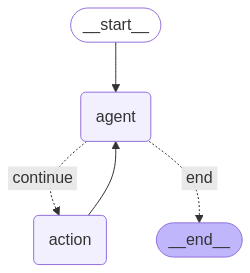

In [22]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

In [23]:
from langchain_core.messages import SystemMessage

system_message = SystemMessage(
    content="You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again"
)
human_message = HumanMessage(content="How is the weather in munich today?")
messages = [system_message, human_message]

result = app.invoke({"messages": messages, "api_call_count": 0})

STATE: {'messages': [SystemMessage(content='You are responsible for answering user questions. You use tools for that, These tools sometimes fail and you are very resilient and trying them again', additional_kwargs={}, response_metadata={}), HumanMessage(content='How is the weather in munich today?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_czfNOeOj5TPdKZcKGQJZXIuF', 'function': {'arguments': '{"city":"Munich"}', 'name': 'fake_weather_api'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 95, 'total_tokens': 113, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c89aaf4f-27b

BadRequestError: Error code: 400 - {'error': {'message': "An assistant message with 'tool_calls' must be followed by tool messages responding to each 'tool_call_id'. The following tool_call_ids did not have response messages: call_SCaZH3o4i4yH2iV7Lyi9jjoV", 'type': 'invalid_request_error', 'param': 'messages', 'code': None}}

In [24]:
print(result["messages"][-1].content)
print(result["api_call_count"])

NameError: name 'result' is not defined